In [77]:
import os
import re
import numpy as np
from numpy import linalg as LA
import pandas as pd
%matplotlib inline 
import matplotlib.pyplot as plt 
from time import gmtime, strftime
from scipy.signal import butter, lfilter,savgol_filter
#from_future_import division

In [16]:
def dataseparation(flocation):
    '''
    this function change the log.file into dataframe form
    
    input: fname: log file location
    
    output: DataFrame
    '''
    #title_akas = pd.read_csv('/Users/seankamano/Downloads/title.akas.tsv', delimiter = '\t', encoding = 'utf-8')
    f_1 = open(flocation, 'r') # read files
    lines = f_1.readlines() # read line by line
    f_1.close() # close the file
    new_lines = []
    for l in lines:
        new_lines.append(l.split('\t')) # remove "\t" by line
    
    mHealth = pd.DataFrame(new_lines)
    return mHealth


def getsubject(dataFrame):
    '''
    input: dataFrame of dataseparation
    output: ECG1, ECG2
            acceleration ax, ay, az
            acceleration a = sqrt( ax^2 + ay^2 + az^2      
    '''
    ECG1 = pd.to_numeric(dataFrame[3])
    ECG2 = pd.to_numeric(dataFrame[4])
    ax = pd.to_numeric(dataFrame[0])
    ay = pd.to_numeric(dataFrame[1])
    az = pd.to_numeric(dataFrame[2])
    a = np.sqrt(ax**2 + ay**2 + az**2)
    return ECG1, ECG2, ax, ay, az, a


def bandpass_filter(data, signal_freq = 50, lowcut = 0.0001, highcut = 3.0, filter_order = 1):
    '''
    this function is to apply butterworth filter
    input: raw data
           float lowcut
           float highcut
           int signal frequency in samples per second
           filter order
    output: filtered data
    '''
    nyquist_freq = 0.5 * signal_freq
    low = lowcut / nyquist_freq
    high = highcut / nyquist_freq
    b, a = butter(filter_order, [low, high], btype = "band")
    y = lfilter(b, a, data)
    return y


def findpeaks(data, spacing=10, limit = 0.01):
        """
        Janko Slavic peak detection algorithm and implementation.
        https://github.com/jankoslavic/py-tools/tree/master/findpeaks
        Finds peaks in `data` which are of `spacing` width and >=`limit`.
        :param ndarray data: data
        :param float spacing: minimum spacing to the next peak (should be 1 or more)
        :param float limit: peaks should have value greater or equal
        :return array: detected peaks indexes array
        """
        len = data.size
        x = np.zeros(len + 2 * spacing)
        x[:spacing] = data[0] - 1.e-6
        x[-spacing:] = data[-1] - 1.e-6
        x[spacing:spacing + len] = data
        peak_candidate = np.zeros(len)
        peak_candidate[:] = True
        for s in range(spacing):
            start = spacing - s - 1
            h_b = x[start: start + len]  # before
            start = spacing
            h_c = x[start: start + len]  # central
            start = spacing + s + 1
            h_a = x[start: start + len]  # after
            peak_candidate = np.logical_and(peak_candidate, np.logical_and(h_c > h_b, h_c > h_a))

        ind = np.argwhere(peak_candidate)
        ind = ind.reshape(ind.size)
        if limit is not None:
            ind = ind[data[ind] > limit]
        return ind
    
    
def detect_peaks(data):
    """
    extracting peaks from loaded ECG measurements data through measurements processing
    input: raw data
    output: peak indices
    """
        # Extract measurements from loaded ECG data.
    ecg_measurements = data

        # Measurements filtering - 0-15 Hz band pass filter.
    filtered_ecg_measurements = bandpass_filter(ecg_measurements)
        #self.filtered_ecg_measurements[:5] = self.filtered_ecg_measurements[5]

        # Derivative - provides QRS slope information.
    differentiated_ecg_measurements = np.ediff1d(filtered_ecg_measurements)

        # Squaring - intensifies values received in derivative.
    squared_ecg_measurements = differentiated_ecg_measurements ** 2

        # Moving-window integration.
    integration_window = 3
    integrated_ecg_measurements = np.convolve(squared_ecg_measurements, np.ones(integration_window))

        # Fiducial mark - peak detection on integrated measurements.
    detected_peaks_indices = findpeaks(data=integrated_ecg_measurements)

    detected_peaks_values = integrated_ecg_measurements[detected_peaks_indices]
    
    return detected_peaks_indices, detected_peaks_values


def ecg2bpm(detected_peaks_indices):
    '''
    this function converts ecg to bpm
    input: detected peaks indices from qrs_detected_indices
    output: peaks_indice and BPM
    '''
    m = 0
    BPM = np.array([])
    time = np.array([])
    for i in detected_peaks_indices[1:]:
        RR_interval = (i - m) # peak-peak intervals
        m_distance = RR_interval / 50.*1000 # calculate the ms distance
        m = i
        bpm = 60000. / m_distance
        time = np.append(time, (i + m) / 2.)
        BPM = np.append(BPM, bpm)
    return time, BPM


def detect_qrs(data, detected_peaks_indices, detected_peaks_values):
        """
        Method responsible for classifying detected ECG measurements peaks either as noise or as QRS complex (heart beat).
        input: raw data, detected_peaks_indices and corresponding valus
        output: qrs_peaks_indices, noise_peaks_indices
        
        """
        refractory_period = 24  # Change proportionally when adjusting frequency (in samples).
        qrs_peak_filtering_factor = 0.125
        noise_peak_filtering_factor = 0.125
        qrs_noise_diff_weight = 0.25
        
        qrs_peak_value = 0.0
        noise_peak_value = 0.0
        threshold_value = 0.0
        
        # Detection results.
        qrs_peaks_indices = np.array([], dtype=int)
        noise_peaks_indices = np.array([], dtype=int)

        # Final ECG data and QRS detection results array - samples with detected QRS are marked with 1 value.
        ecg_data_detected = None

        for detected_peak_index, detected_peaks_value in zip(detected_peaks_indices, detected_peaks_values):

            try:
                last_qrs_index = qrs_peaks_indices[-1]
            except IndexError:
                last_qrs_index = 0

            # After a valid QRS complex detection, there is a 200 ms refractory period before next one can be detected.
            if detected_peak_index - last_qrs_index > refractory_period or not qrs_peaks_indices.size:
                # Peak must be classified either as a noise peak or a QRS peak.
                # To be classified as a QRS peak it must exceed dynamically set threshold value.
                if detected_peaks_value > threshold_value:
                    qrs_peaks_indices = np.append(qrs_peaks_indices, detected_peak_index)

                    # Adjust QRS peak value used later for setting QRS-noise threshold.
                    qrs_peak_value = qrs_peak_filtering_factor * detected_peaks_value + \
                                          (1 - qrs_peak_filtering_factor) * qrs_peak_value
                else:
                    noise_peaks_indices = np.append(noise_peaks_indices, detected_peak_index)

                    # Adjust noise peak value used later for setting QRS-noise threshold.
                    noise_peak_value = noise_peak_filtering_factor * detected_peaks_value + \
                                            (1 - noise_peak_filtering_factor) * noise_peak_value

                # Adjust QRS-noise threshold value based on previously detected QRS or noise peaks value.
                threshold_value = noise_peak_value + \
                                       qrs_noise_diff_weight * (qrs_peak_value - noise_peak_value)

        # Create array containing both input ECG measurements data and QRS detection indication column.
        # We mark QRS detection with '1' flag in 'qrs_detected' log column ('0' otherwise).
        measurement_qrs_detection_flag = np.zeros([len(data), 1])
        measurement_qrs_detection_flag[qrs_peaks_indices] = 1
        ecg_data_detected_ = np.append(data, measurement_qrs_detection_flag)
        ecg_data_detected = np.append(ecg_data_detected_, 1)
        
        #return measurement_qrs_detection_flag
        #return ecg_data_detected
        return qrs_peaks_indices, noise_peaks_indices
    
def activitylevel(acc):
    '''
    input: param: acc type: narray acceleration values
    output: activity level using equation sqrt(delt_a**2 + delt_t**2)
            since the sampling rate is 50 Hz, we would like to obtain the activity level 
            withini a second, considering 50 samples at a time and only caring about the 
            differences in acceleration and time in a short period
    
    '''
    n = 0
    act_level = np.array([])
    while n < len(acc)-50:
        delt_sum = 0
        for i in range(25):
            delta = acc[n + (i+1) * 2] - acc[n + 2*i]
            deltt = 5 * 0.02 
            delt_sum = np.sqrt(delta**2 + deltt**2) + delt_sum
   
        act_level = np.append(act_level, delt_sum)
        n = n + 50
        
    return act_level

In [17]:
def lowpass():
        Fs = 1000
        Fpass = 200
        Fstop = 400
        Dpass = 0.05
        Dstop = 0.0001
        F = np.array([0, Fpass, Fstop, Fs/2.])
        A = np.array([[1,1], [0,0]])
        D = np.array([Dpass, Dstop])

In [18]:
filelocation = "/Users/13391/Documents/1_knowledge/MS1_SP/ECE251B/MHEALTHDATASET/mHealth_subject3.log"
mHealth = dataseparation(filelocation)
ECG1, ECG2, ax, ay, az, a = getsubject(mHealth)

In [19]:
ecg_measurements = ECG1[65000:80000].values # first minute 50 points per second
acc = az[65000:80000].values
detected_peaks_indices, detected_peaks_values = detect_peaks(ecg_measurements)

In [20]:
qrs_peaks_indices, noise_peaks_indices = detect_qrs(ECG1.values, detected_peaks_indices, detected_peaks_values)
print noise_peaks_indices.shape
time, BPM = ecg2bpm(qrs_peaks_indices)
print len(BPM), len(time)

act_level = activitylevel(acc)
print ('activity level', act_level.shape)

(2L,)
410 410
('activity level', (299L,))


('mean value: ', 84.21773612604369)
('largest value: ', 120.0)


Text(0.5,1,u'Activity Level')

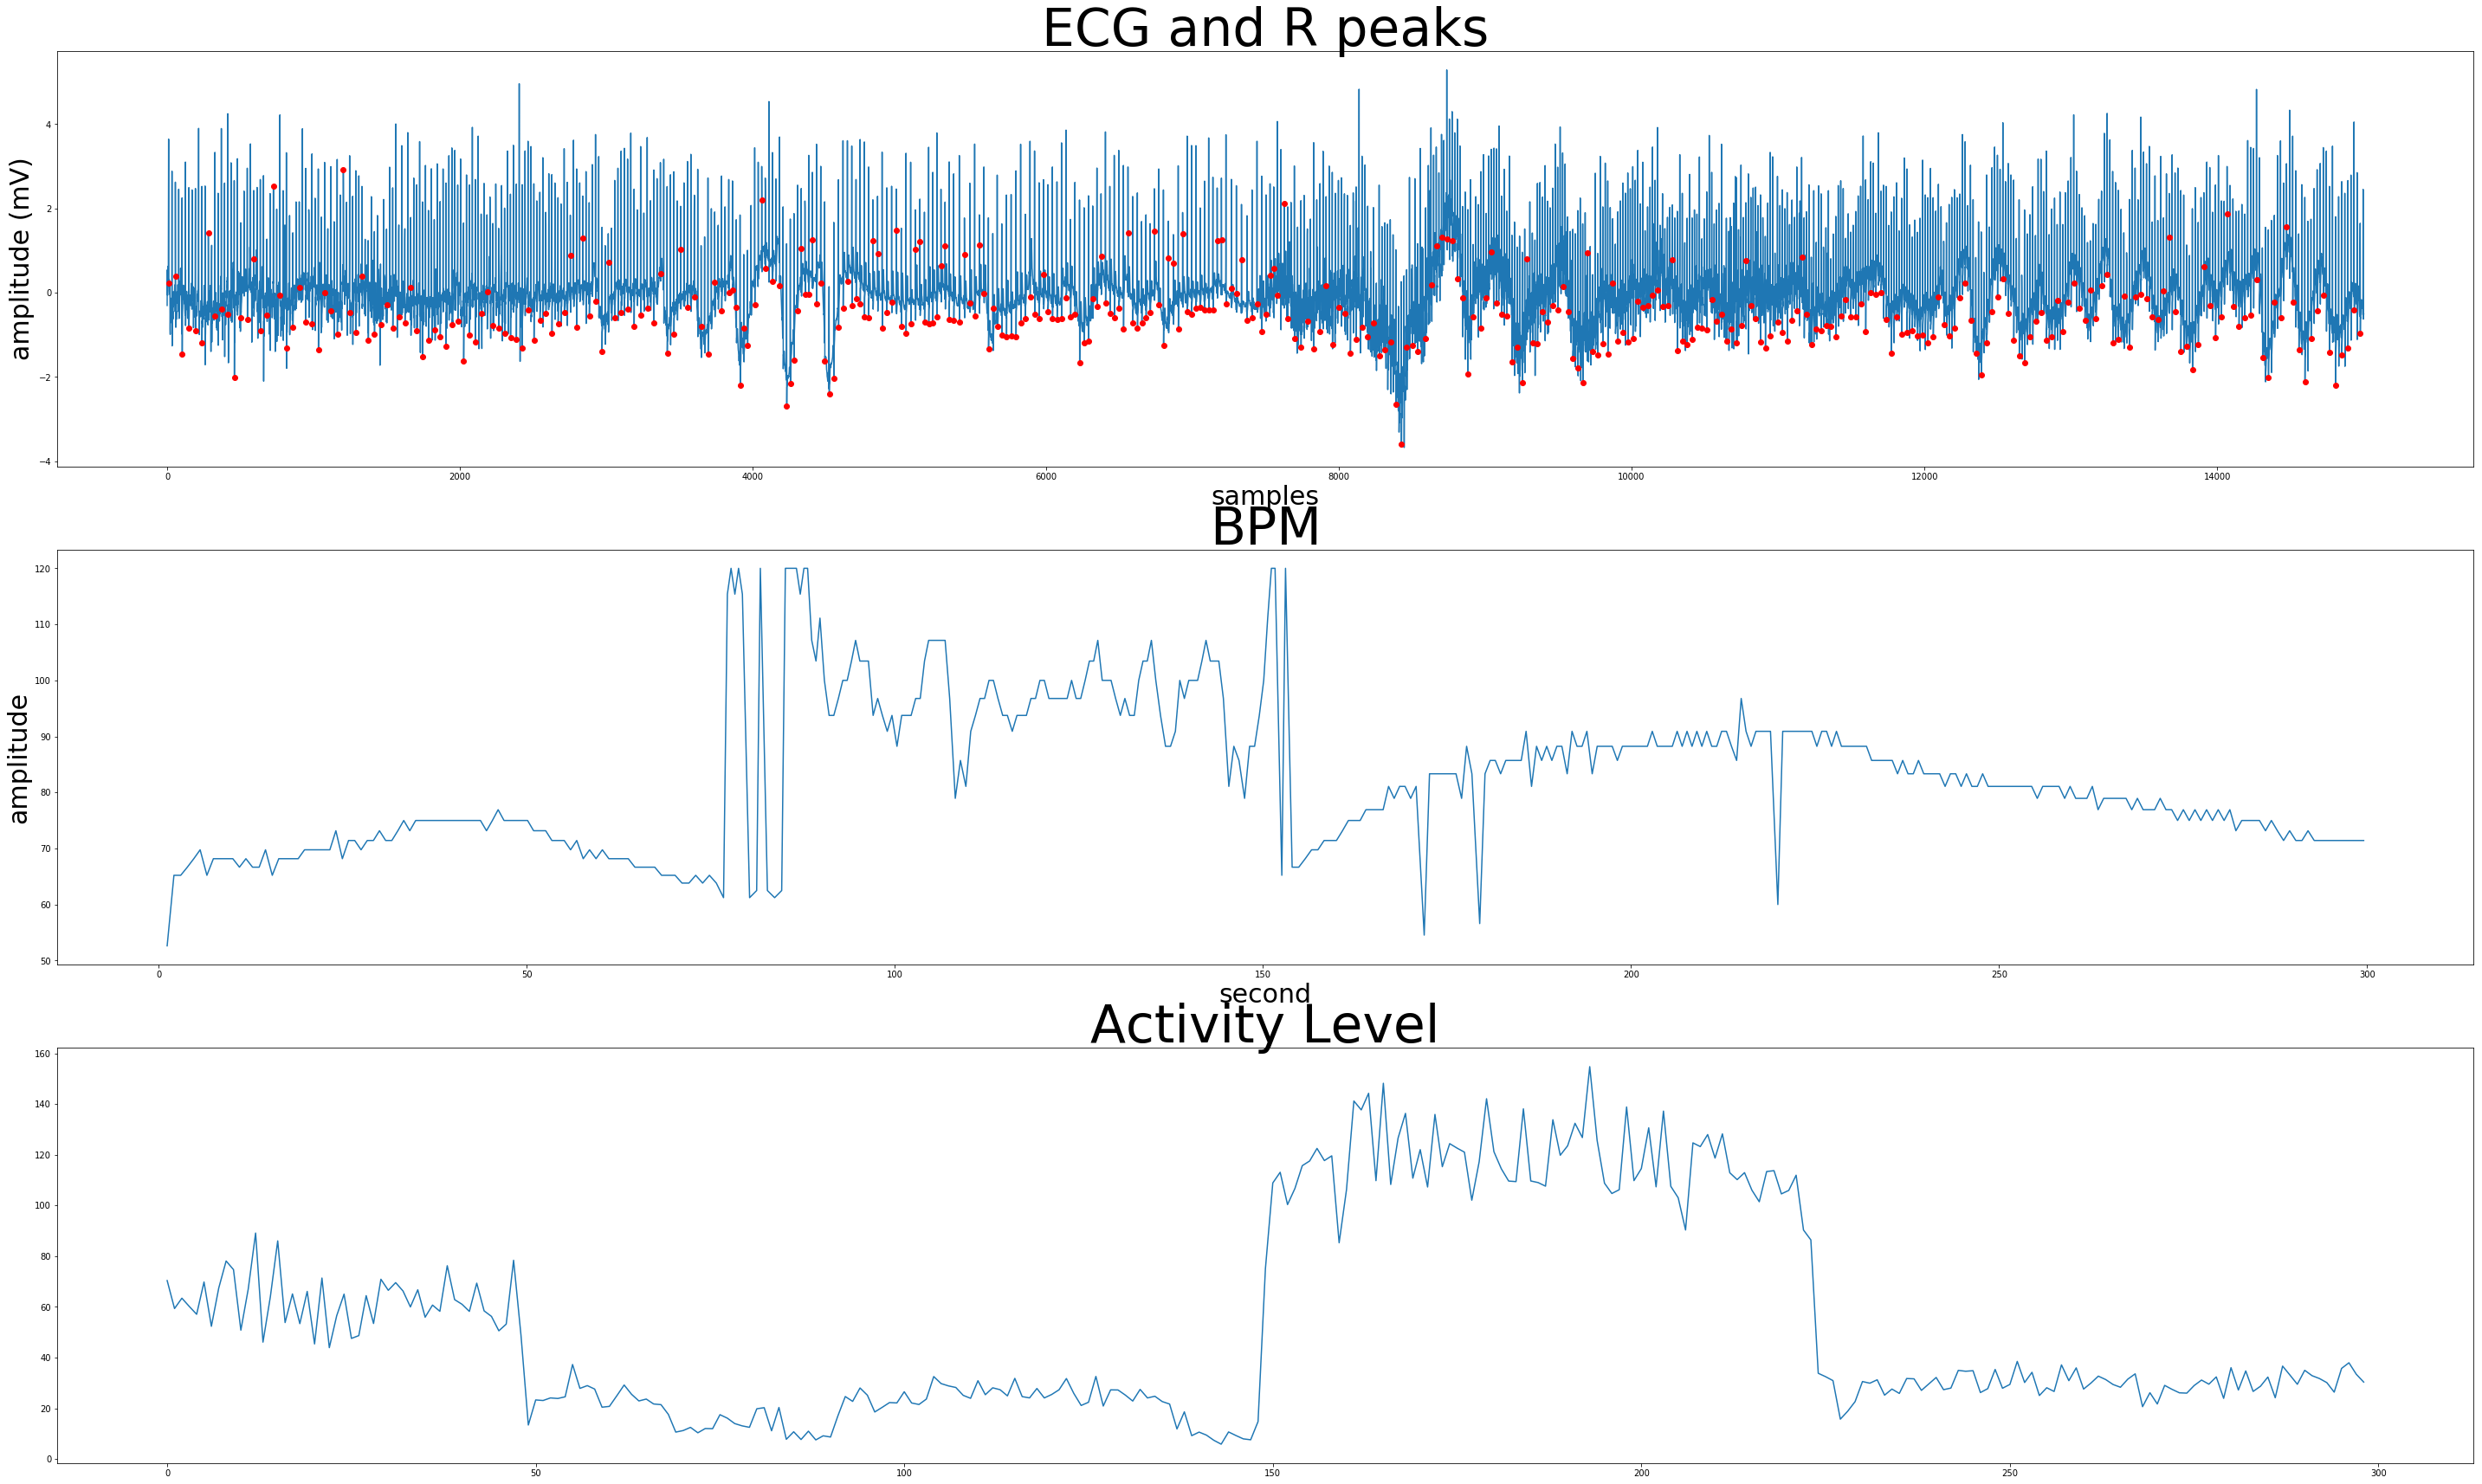

In [21]:
fig = plt.figure(figsize=(50, 30))


subplot1 = fig.add_subplot(311)
subplot2 = fig.add_subplot(312)
subplot3 = fig.add_subplot(313)
subplot1.plot(ecg_measurements)
subplot1.plot(qrs_peaks_indices, ecg_measurements[qrs_peaks_indices], 'ro' )
subplot1.set_title('ECG and R peaks', fontsize = 60)
subplot1.set_xlabel('samples', fontsize = 30)
subplot1.set_ylabel('amplitude (mV)', fontsize = 30)

subplot2.plot(time*0.02, BPM)
subplot2.set_title('BPM', fontsize = 60)
subplot2.set_xlabel('second', fontsize = 30)
subplot2.set_ylabel('amplitude', fontsize = 30)
print ("mean value: ", BPM.mean())
print ("largest value: ", BPM.max())

subplot3.plot(act_level)
subplot3.set_title('Activity Level', fontsize = 60)

In [22]:
np.shape(ECG1)

(122112L,)

In [23]:
np.shape(ECG2)

(122112L,)

In [25]:
E1=ECG1[65000:65100]

In [26]:
np.shape(E1)

(100L,)

In [27]:
fig = plt.figure(figsize=(50, 30))
subplot1.plot(E1)

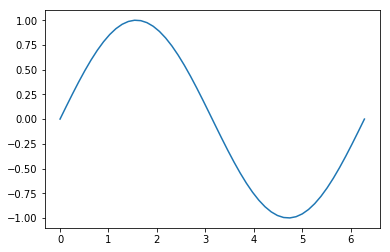

In [28]:
x = np.linspace(0, 2 * np.pi, 50)
plt.plot(x, np.sin(x)) # 如果没有第一个参数 x，图形的 x 坐标默认为数组的索引
plt.show() # 显示图形

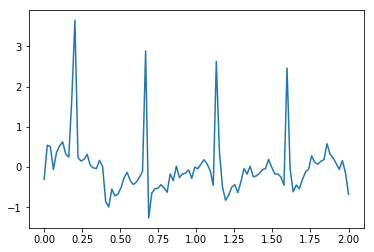

In [37]:
x = np.linspace(0, 2, 100)
plt.plot(x, E1) # 如果没有第一个参数 x，图形的 x 坐标默认为数组的索引
#plt.xticks(np.linspace(0, 1, 100))
plt.show() # 显示图形

In [38]:
P=detect_peaks(E1)

In [39]:
np.shape(P)

(2L, 5L)

In [40]:
#aa = [1,2,3,4,5]

#aa.index(max(aa))

#如果aa是numpy数组：

#aa = numpy.array([1,2,3,4,5])

#先把aa转换为List，再求索引：

#bb = aa.tolist()

#bb.index(max(bb))
eb=E1.tolist()
eb.index(max(eb))

10

In [44]:
MAX=max(eb)

In [45]:
MIN=min(eb)

In [43]:
eb.index(min(eb))

34

In [47]:
TH=(MAX+MIN)/2
print TH

1.1931


In [48]:
eb.index(eb>TH)

ValueError: True is not in list

In [49]:
#a for a in range(len(y)) if y[a] == x
for i in range(len(eb)):
    if(eb[i]>TH):
        print i

9
10
33
56
79


In [50]:
print TH

1.1931


In [51]:
eb[9]

1.7206

In [52]:
eb[8]

0.25118

In [53]:
eb[100]

IndexError: list index out of range

In [54]:
eb[99]

-0.67399

In [55]:
eb(0)

TypeError: 'list' object is not callable

In [56]:
eb[0]

-0.30141

In [59]:
TH=MIN+3*(MAX-MIN)/4
print TH

2.4197


In [60]:
for i in range(len(eb)):
    if(eb[i]>TH):
        print i

10
33
56
79


In [72]:
flag1=0
flag2=0
for i in range(len(eb)):
    if(eb[i]>TH):
        if(flag1==0):
            tmp1=i
            flag1=1
        elif (flag2==0):
            tmp2=i
            flag2=1
deltat=tmp2-tmp1
print deltat

23


In [76]:
bpm=60./(deltat/50.)

In [78]:
print bpm

130.434782609


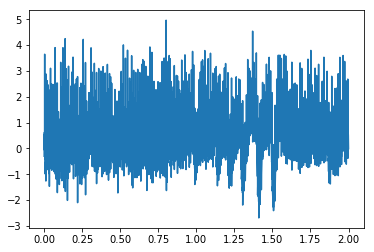

In [80]:
ECGTEST=ECG1[65000:71000]
x = np.linspace(0, 2, 6000)
plt.plot(x, ECGTEST) # 如果没有第一个参数 x，图形的 x 坐标默认为数组的索引
#plt.xticks(np.linspace(0, 1, 100))
plt.show() # 显示图形

In [81]:
for i in range(59):
    print i

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58


In [82]:
eb[0]

-0.30141

In [87]:
et=ECGTEST.tolist()
listBPM = [];
for i in range(59):
    eb=et[50*i:50*(i+2)]
    MAX=max(eb)
    MIN=min(eb)
    TH=MIN+3*(MAX-MIN)/4
    flag1=0
    flag2=0
    for j in range(len(eb)):
        if(eb[j]>TH):
            if(flag1==0):
                tmp1=j
                flag1=1
            elif (flag2==0):
                tmp2=j
                flag2=1
    deltat=tmp2-tmp1
    bpm=60./(deltat/50.)
    listBPM.append(bpm);

    
    

In [84]:
listBPM

[130.43478260869566,
 130.43478260869566,
 130.43478260869566,
 3000.0,
 500.0,
 250.0,
 136.36363636363637,
 136.36363636363637,
 136.36363636363637,
 136.36363636363637,
 136.36363636363637,
 136.36363636363637,
 136.36363636363637,
 107.14285714285714,
 136.36363636363637,
 600.0,
 272.72727272727275,
 136.36363636363637,
 136.36363636363637,
 428.57142857142856,
 3000.0,
 -214.28571428571428,
 -428.57142857142856,
 142.85714285714286,
 69.76744186046511,
 142.85714285714286,
 142.85714285714286,
 -214.28571428571428,
 150.0,
 3000.0,
 142.85714285714286,
 103.44827586206897,
 73.17073170731707,
 333.33333333333337,
 150.0,
 300.0,
 75.0,
 150.0,
 150.0,
 150.0,
 75.0,
 300.0,
 150.0,
 150.0,
 3000.0,
 -103.44827586206897,
 150.0,
 150.0,
 75.0,
 150.0,
 150.0,
 333.33333333333337,
 142.85714285714286,
 142.85714285714286,
 142.85714285714286,
 142.85714285714286,
 142.85714285714286,
 136.36363636363637,
 136.36363636363637]

In [85]:
len(listBPM)

59

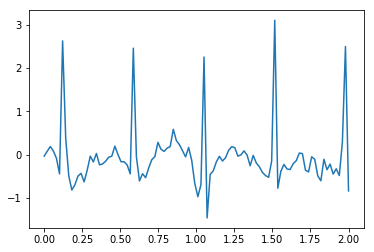

In [88]:
E1=ECG1[65050:65150]
x = np.linspace(0, 2, 100)
plt.plot(x, E1) # 如果没有第一个参数 x，图形的 x 坐标默认为数组的索引
#plt.xticks(np.linspace(0, 1, 100))
plt.show() # 显示图形

In [92]:
eb=E1.tolist()
MAX=max(eb)
MIN=min(eb)
TH=MIN+3*(MAX-MIN)/4
flag1=0
flag2=0
for j in range(len(eb)):
    if(eb[j]>TH):
        if(flag1==0):
            tmp1=j
            flag1=1
        elif (flag2==0):
            tmp2=j
            flag2=1
deltat=tmp2-tmp1
bpm=60./(deltat/50.)

In [93]:
bpm

130.43478260869566

In [94]:
tmp1

6

In [95]:
tmp2

29

In [129]:
i=14;
E1=ECG1[65000+50*i:65000+50*(i+2)]
eb=E1.tolist()
MAX=max(eb)
MIN=min(eb)
TH=MIN+7*(MAX-MIN)/10
flag1=0
flag2=0
for j in range(len(eb)):
    if(eb[j]>TH):
        if(flag1==0):
            tmp1=j
            flag1=1
        elif (flag2==0):
            tmp2=j
            flag2=1
deltat=tmp2-tmp1
bpm=60./(deltat/50.)
print bpm

-68.1818181818


In [97]:
bpm

-83.33333333333334

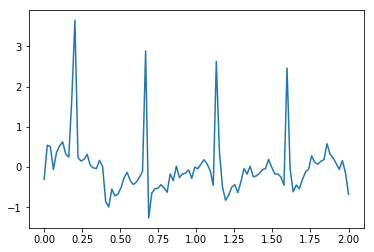

In [138]:
E1=ECG1[65000+50*0:65000+50*(0+2)]
x = np.linspace(0, 2, 100)
plt.plot(x, E1) # 如果没有第一个参数 x，图形的 x 坐标默认为数组的索引
#plt.xticks(np.linspace(0, 1, 100))
plt.show() # 显示图形

In [139]:
tmp2

25

In [140]:
tmp1

3

In [149]:
eb=E1.tolist()
MAX=max(eb)
MIN=min(eb)
TH=MIN+5*(MAX-MIN)/10
flag1=0
flag2=0
for j in range(len(eb)):
    if(eb[j]>TH):
        if(flag1==0):
            tmp1=j
            flag1=1
        elif (flag2==0 and j-tmp1>10):
            tmp2=j
            flag2=1
deltat=tmp2-tmp1
bpm=60./(deltat/50.)

In [150]:
bpm

125.0

In [153]:
tmp1

9

In [154]:
tmp2

33

In [135]:
eb=E1.tolist()
MAX=max(eb)
MIN=min(eb)
TH=MIN+5*(MAX-MIN)/10
flag1=0
flag2=0
for j in range(len(eb)):
    if(eb[j]>TH):
        if(flag1==0):
            tmp1=j
            flag1=1
        elif (flag2==0):
            tmp2=j
            flag2=1
deltat=tmp2-tmp1
bpm=60./(deltat/50.)

In [136]:
bpm

136.36363636363637

In [127]:
E1=ECG1[65000+50*14:65000+100*(14+1)]
np.shape(E1)

(800L,)

In [128]:
E1=ECG1[65000+50*14:65000+50*(14+2)]
np.shape(E1)

(100L,)

In [159]:
et=ECGTEST.tolist()
listBPM = [];
for i in range(59):
    eb=et[50*i:50*(i+2)]
    MAX=max(eb)
    MIN=min(eb)
    TH=MIN+5*(MAX-MIN)/10
    flag1=0
    flag2=0
    for j in range(len(eb)):
        if(eb[j]>TH):
            if(flag1==0):
                tmp1=j
                flag1=1
            elif (flag2==0 and j-tmp1>14):
                tmp2=j
                flag2=1
    deltat=tmp2-tmp1
    bpm=60./(deltat/50.)
    listBPM.append(bpm);

In [160]:
 listBPM

[125.0,
 130.43478260869566,
 130.43478260869566,
 130.43478260869566,
 136.36363636363637,
 136.36363636363637,
 136.36363636363637,
 136.36363636363637,
 136.36363636363637,
 103.44827586206897,
 136.36363636363637,
 136.36363636363637,
 90.9090909090909,
 103.44827586206897,
 136.36363636363637,
 136.36363636363637,
 93.75,
 136.36363636363637,
 136.36363636363637,
 136.36363636363637,
 136.36363636363637,
 136.36363636363637,
 136.36363636363637,
 142.85714285714286,
 142.85714285714286,
 142.85714285714286,
 142.85714285714286,
 142.85714285714286,
 90.9090909090909,
 150.0,
 142.85714285714286,
 142.85714285714286,
 142.85714285714286,
 150.0,
 150.0,
 150.0,
 150.0,
 150.0,
 150.0,
 157.89473684210526,
 150.0,
 150.0,
 150.0,
 150.0,
 125.0,
 150.0,
 150.0,
 150.0,
 150.0,
 150.0,
 150.0,
 150.0,
 142.85714285714286,
 142.85714285714286,
 142.85714285714286,
 136.36363636363637,
 142.85714285714286,
 136.36363636363637,
 136.36363636363637]